In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sklearn
from sklearn.datasets import make_circles

In [3]:
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "Label": y})
circles.sample(5)

,X1,X2,Label
530,0.638670,0.534520,1
643,0.739219,-0.345673,1
426,0.490081,0.850842,0
7,0.771513,0.147760,1
379,-0.568874,-0.563301,1


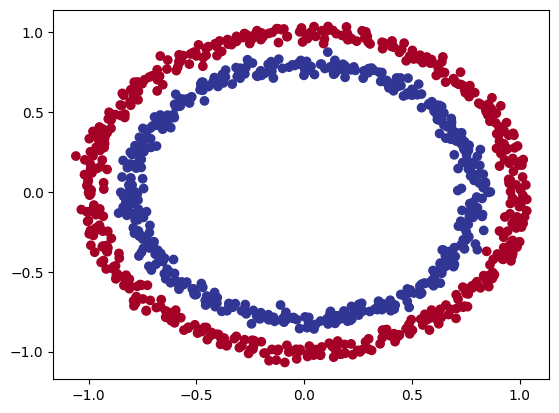

In [6]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
torch.__version__

'2.6.0+cu124'

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [13]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

In [14]:
X_train.shape

torch.Size([800, 2])

1. Sbuclasses `nn.Module` (almost all models in PyTorch subclass ``nn.Module``.
2. Create 2 ``nn.Linear()`` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target

In [15]:
class CircleModelv0(nn.Module):
  def __init__(self):
    super().__init__()
    # self.layer_1 = nn.Linear(in_features=2, out_features=5)
    # self.layer_2 = nn.Linear(in_features=5, out_features=1)

    self.two_linear_layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=5),
        nn.Linear(in_features=5, out_features=1)
    )

  def forward(self, x):
    # return self.layer_2(self.layer_1(x))
    return two_linear_layers(x)

model_0 = CircleModelv0().to(device)
model_0

CircleModelv0(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [16]:
# Replicating the model CircleModelV0 using nn.sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1423,  0.4397],
                      [ 0.6009,  0.3044],
                      [-0.2325,  0.3374],
                      [-0.5652,  0.5536],
                      [ 0.2079, -0.6448]])),
             ('0.bias', tensor([-0.0227,  0.5513,  0.3329,  0.1074,  0.0982])),
             ('1.weight',
              tensor([[-0.0498, -0.2510,  0.3755,  0.1910, -0.0076]])),
             ('1.bias', tensor([0.0411]))])

In [18]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")

Length of predictions: 200, Shape: torch.Size([200, 1])


## Setting up Loss function and optimizer

For regression you might want MSE or MAE

For classification you might want Binary Cross Entropy or Categorial Cross Entropy (Cross Entropy)

For optimizers, two of the most common and useful are SGD and Adam

In [19]:
# loss_fn = nn.BCELoss() - Requires input to have gone through sigmoid activation function
loss_fn = nn.BCEWithLogitsLoss() # BCEwithLogitsLoss - Sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [20]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## Model training

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Backpropagation
5. Gradient Descent

In [21]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.2767],
        [ 0.1767],
        [ 0.2542],
        [ 0.2842],
        [-0.1975]])

In [22]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5687],
        [0.5441],
        [0.5632],
        [0.5706],
        [0.4508]])

In [23]:
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]])

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

For the predicted probability values
* `y_pred_probs` >= 0.5, `y=1`(Class 1)
* `y_pred_probs` < 0.5, `y=0`(Class 0)

In [25]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

In [26]:
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True])


In [27]:
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate loss/accuracy
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Gradient descent
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.70103, Acc: 50.12% | Test loss: 0.69941, Test acc: 51.50
Epoch: 10 | Loss: 0.69933, Acc: 50.00% | Test loss: 0.69774, Test acc: 50.50
Epoch: 20 | Loss: 0.69808, Acc: 49.88% | Test loss: 0.69653, Test acc: 50.00
Epoch: 30 | Loss: 0.69714, Acc: 50.38% | Test loss: 0.69565, Test acc: 49.50
Epoch: 40 | Loss: 0.69642, Acc: 50.38% | Test loss: 0.69499, Test acc: 50.50
Epoch: 50 | Loss: 0.69585, Acc: 50.62% | Test loss: 0.69449, Test acc: 50.00
Epoch: 60 | Loss: 0.69540, Acc: 50.62% | Test loss: 0.69412, Test acc: 49.00
Epoch: 70 | Loss: 0.69503, Acc: 50.50% | Test loss: 0.69384, Test acc: 48.50
Epoch: 80 | Loss: 0.69474, Acc: 50.38% | Test loss: 0.69363, Test acc: 48.50
Epoch: 90 | Loss: 0.69449, Acc: 50.38% | Test loss: 0.69347, Test acc: 49.00


From the metrics the model isn't learning.

In [28]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download heplper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


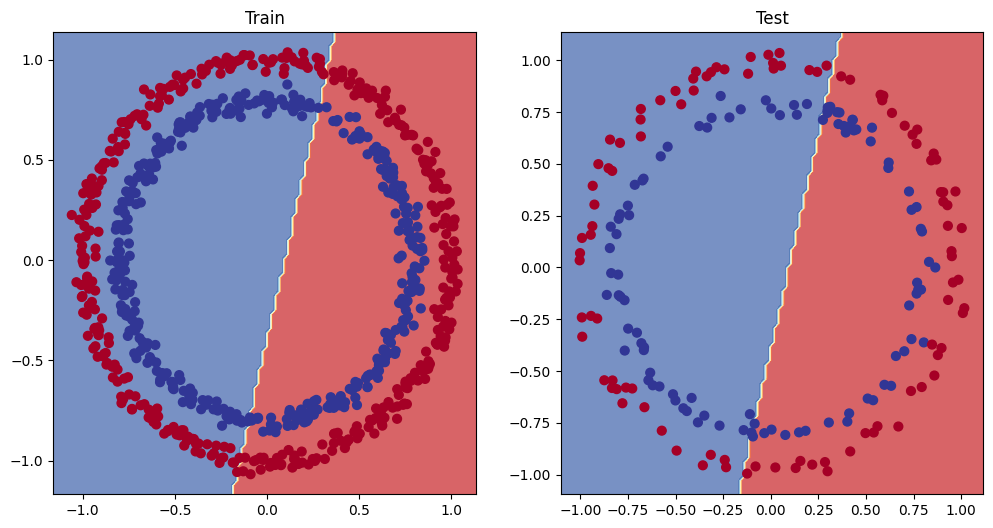

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving a model ( from a model perspective )

* Add more layers - give the model more chances to learn about pattterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer - More epochs
* Changing the activation functions
* Change the learning rate

In [30]:
class CircleModelv1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z - self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # This way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelv1().to(device)
model_1

CircleModelv1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
# Loss function
loss_fn1 = torch.nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [32]:
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> predictions

  # Calculate loss/accuracy
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Gradient descent
  optimizer.step()

  # Testing
  model_1.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.70143, Acc: 50.00% | Test loss: 0.70431, Test acc: 50.00
Epoch: 10 | Loss: 0.69590, Acc: 46.00% | Test loss: 0.69913, Test acc: 43.00
Epoch: 20 | Loss: 0.69417, Acc: 47.38% | Test loss: 0.69730, Test acc: 47.00
Epoch: 30 | Loss: 0.69358, Acc: 49.50% | Test loss: 0.69650, Test acc: 47.50
Epoch: 40 | Loss: 0.69334, Acc: 49.50% | Test loss: 0.69608, Test acc: 46.00
Epoch: 50 | Loss: 0.69323, Acc: 50.88% | Test loss: 0.69580, Test acc: 47.00
Epoch: 60 | Loss: 0.69316, Acc: 50.62% | Test loss: 0.69560, Test acc: 47.00
Epoch: 70 | Loss: 0.69312, Acc: 51.00% | Test loss: 0.69545, Test acc: 47.00
Epoch: 80 | Loss: 0.69309, Acc: 51.38% | Test loss: 0.69533, Test acc: 46.00
Epoch: 90 | Loss: 0.69307, Acc: 51.12% | Test loss: 0.69523, Test acc: 47.00
Epoch: 100 | Loss: 0.69305, Acc: 51.00% | Test loss: 0.69515, Test acc: 46.50
Epoch: 110 | Loss: 0.69303, Acc: 50.75% | Test loss: 0.69508, Test acc: 45.50
Epoch: 120 | Loss: 0.69302, Acc: 50.75% | Test loss: 0.69503, Test acc: 45.

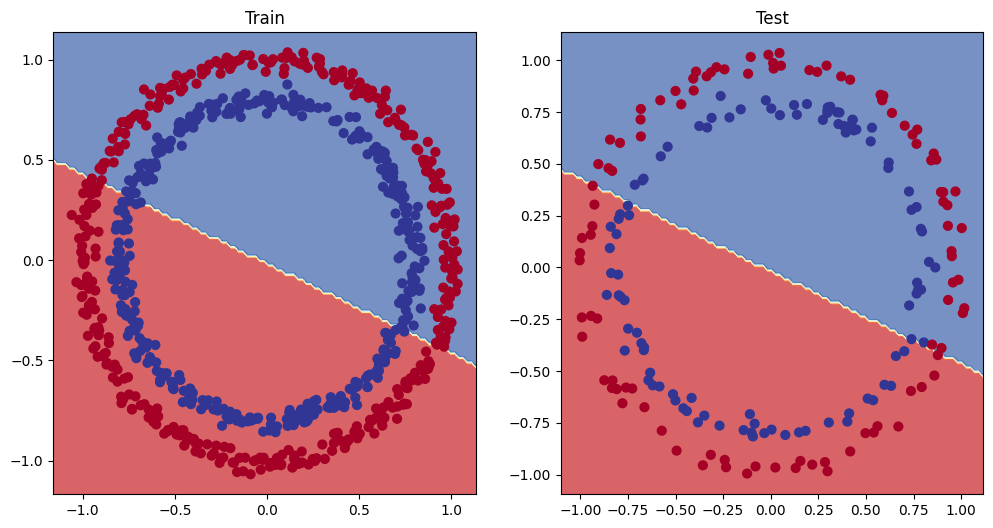

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [34]:
class CircleModelv2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.ReLU()
    self.layer_3 = nn.Linear(in_features=10, out_features=10)
    self.layer_4 = nn.ReLU()
    self.layer_5 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    z = self.layer_1(x)
    z = self.layer_2(z)
    z = self.layer_3(z)
    z = self.layer_4(z)
    z = self.layer_5(z)
    return z
    # return self.layer_3(self.layer_2(self.layer_1(x))) # This way of writing operations leverages speed ups where possible behind the scenes

model_2 = CircleModelv2().to(device)
model_2

CircleModelv2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): ReLU()
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
  (layer_4): ReLU()
  (layer_5): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [36]:
epochs = 1200

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_2.train()

  # Forward pass
  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> predictions

  # Calculate loss/accuracy
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Gradient descent
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69152, Acc: 52.75% | Test loss: 0.69247, Test acc: 49.50
Epoch: 10 | Loss: 0.69116, Acc: 52.75% | Test loss: 0.69202, Test acc: 49.00
Epoch: 20 | Loss: 0.69077, Acc: 52.50% | Test loss: 0.69156, Test acc: 51.50
Epoch: 30 | Loss: 0.69033, Acc: 52.38% | Test loss: 0.69110, Test acc: 51.50
Epoch: 40 | Loss: 0.69007, Acc: 52.62% | Test loss: 0.69078, Test acc: 52.50
Epoch: 50 | Loss: 0.68981, Acc: 54.25% | Test loss: 0.69046, Test acc: 53.50
Epoch: 60 | Loss: 0.68955, Acc: 55.88% | Test loss: 0.69014, Test acc: 55.50
Epoch: 70 | Loss: 0.68929, Acc: 58.50% | Test loss: 0.68982, Test acc: 56.50
Epoch: 80 | Loss: 0.68903, Acc: 59.62% | Test loss: 0.68950, Test acc: 58.00
Epoch: 90 | Loss: 0.68876, Acc: 61.88% | Test loss: 0.68918, Test acc: 60.00
Epoch: 100 | Loss: 0.68849, Acc: 63.88% | Test loss: 0.68886, Test acc: 63.50
Epoch: 110 | Loss: 0.68822, Acc: 66.00% | Test loss: 0.68854, Test acc: 65.50
Epoch: 120 | Loss: 0.68794, Acc: 64.62% | Test loss: 0.68823, Test acc: 64.

In [37]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [38]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

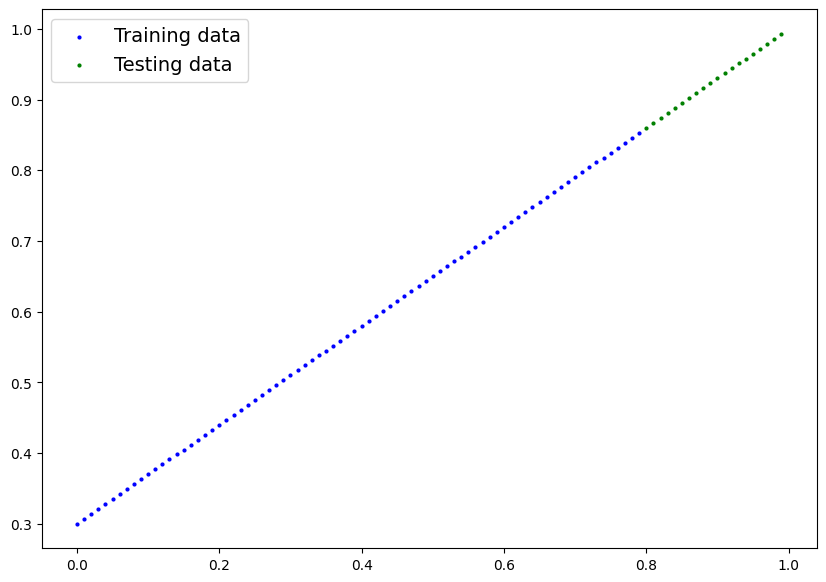

In [39]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

## Adjusting `Model_1` to fit a straight line

In [40]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [42]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Putting the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.68910 | Test loss: 0.38503
Epoch: 100 | Loss: 0.06641 | Test loss: 0.20925
Epoch: 200 | Loss: 0.04943 | Test loss: 0.17287
Epoch: 300 | Loss: 0.05537 | Test loss: 0.14180
Epoch: 400 | Loss: 0.06954 | Test loss: 0.14424
Epoch: 500 | Loss: 0.06737 | Test loss: 0.13854
Epoch: 600 | Loss: 0.04871 | Test loss: 0.13585
Epoch: 700 | Loss: 0.06226 | Test loss: 0.13518
Epoch: 800 | Loss: 0.04597 | Test loss: 0.12265
Epoch: 900 | Loss: 0.06659 | Test loss: 0.11803


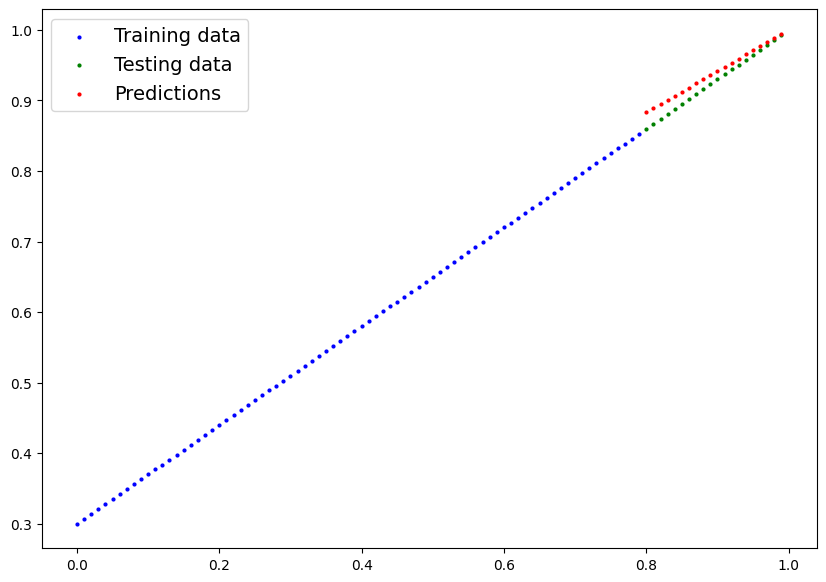

In [43]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

In [44]:
import torch
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## Builing a non-linear model

* Linear = straight linear
* Non-linear = non-straight lines

In [45]:
from torch import nn
class CircleModelv3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # Non-linear activation function

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelv3().to(device)
model_3

CircleModelv3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [46]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [47]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()

  # Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> predictions

  # Calculate loss/accuracy
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Gradient descent
  optimizer.step()

  # Testing
  model_3.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test loss: 0.69319, Test acc: 50.00
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test loss: 0.69102, Test acc: 52.50
Epoch: 200 | Loss: 0.68977, Acc: 53.37% | Test loss: 0.68940, Test acc: 55.00
Epoch: 300 | Loss: 0.68795, Acc: 53.00% | Test loss: 0.68723, Test acc: 56.00
Epoch: 400 | Loss: 0.68517, Acc: 52.75% | Test loss: 0.68411, Test acc: 56.50
Epoch: 500 | Loss: 0.68102, Acc: 52.75% | Test loss: 0.67941, Test acc: 56.50
Epoch: 600 | Loss: 0.67515, Acc: 54.50% | Test loss: 0.67285, Test acc: 56.00
Epoch: 700 | Loss: 0.66659, Acc: 58.38% | Test loss: 0.66322, Test acc: 59.00
Epoch: 800 | Loss: 0.65160, Acc: 64.00% | Test loss: 0.64757, Test acc: 67.50
Epoch: 900 | Loss: 0.62362, Acc: 74.00% | Test loss: 0.62145, Test acc: 79.00
Epoch: 1000 | Loss: 0.56818, Acc: 87.75% | Test loss: 0.57378, Test acc: 86.50
Epoch: 1100 | Loss: 0.48153, Acc: 93.50% | Test loss: 0.49935, Test acc: 90.50
Epoch: 1200 | Loss: 0.37056, Acc: 97.75% | Test loss: 0.40595, T

In [48]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

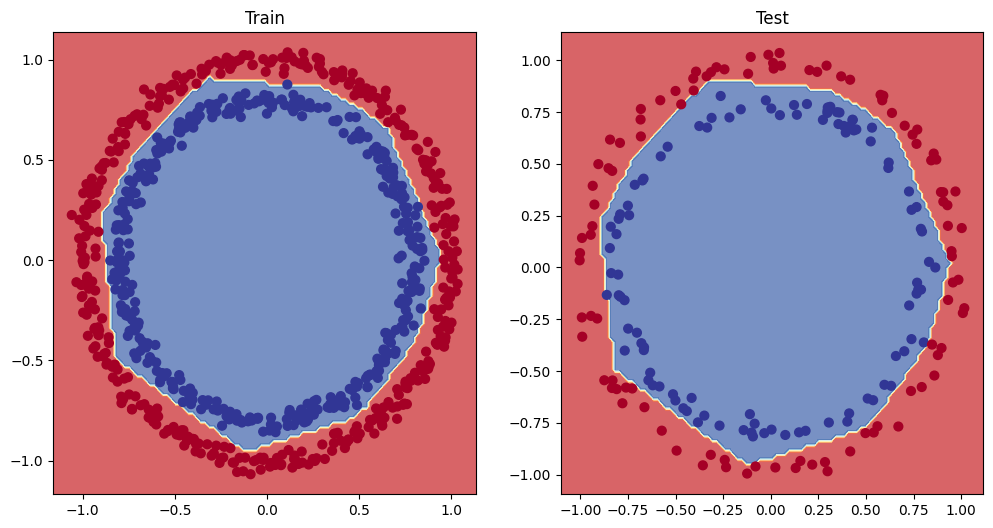

In [49]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## Replicating Non-Linear activation functions

In [50]:
A = torch.arange(-10, 10, 1).type(torch.float)
A.dtype

torch.float32

In [51]:
def relu(x):
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

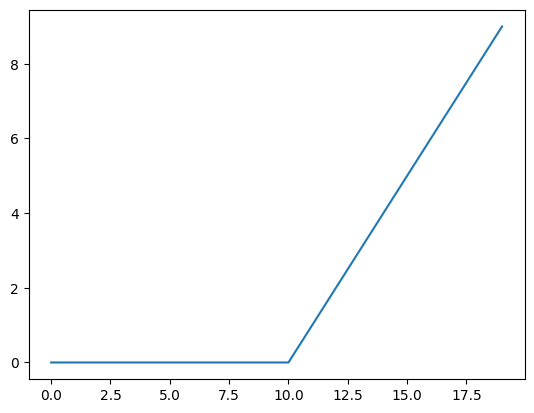

In [52]:
plt.plot(relu(A))

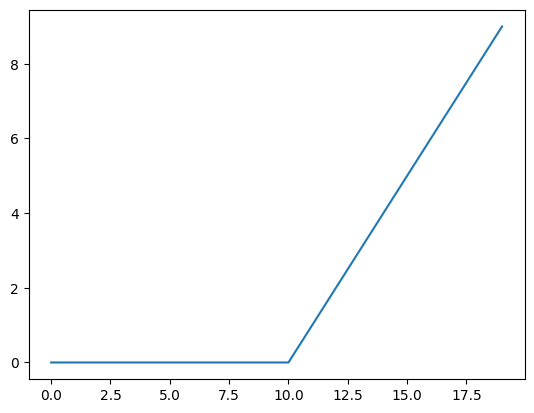

In [53]:
plt.plot(torch.relu(A))

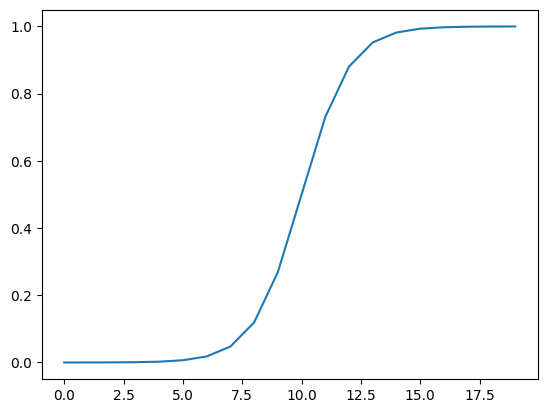

In [54]:
plt.plot(torch.sigmoid(A))

In [55]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

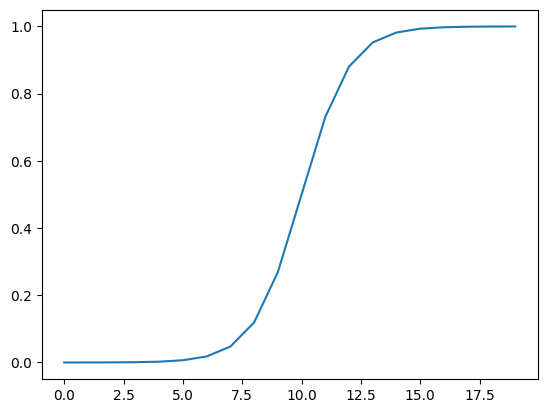

In [56]:
plt.plot(sigmoid(A))

## Multiclass classification

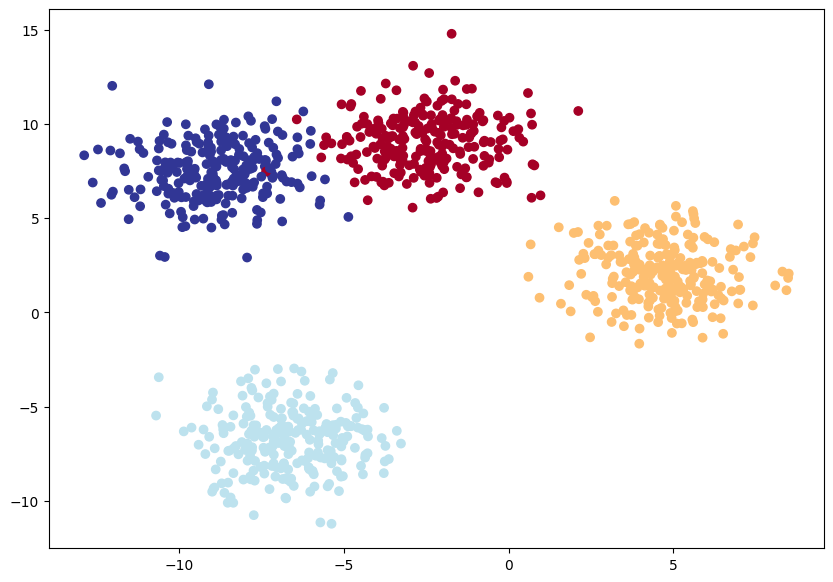

In [57]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

#
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=4,
                            cluster_std=1.5, # Mix them a bit
                            random_state=RANDOM_SEED
)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# Plotting data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [59]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8
    """
    super().__init__()
    self.linear_layer_stack =  nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [60]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [61]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

In [62]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5], y_logits[:5]

(tensor([[0.3169, 0.3244, 0.1405, 0.2182],
         [0.3336, 0.1432, 0.2026, 0.3206],
         [0.3011, 0.1843, 0.2823, 0.2323],
         [0.3078, 0.2766, 0.1836, 0.2320],
         [0.3719, 0.1286, 0.1532, 0.3463]]),
 tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.4134, -0.5204, -0.9303, -0.6963],
         [-0.3118, -1.3736, -1.1991, -0.3834]]))

In [63]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [64]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [65]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ## Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.1588, Acc: 40.38% | Test loss: 1.0755, Test acc: 48.00%
Epoch: 10 | Loss: 0.6448, Acc: 96.75% | Test loss: 0.6607, Test acc: 97.50%
Epoch: 20 | Loss: 0.4254, Acc: 98.50% | Test loss: 0.4307, Test acc: 100.00%
Epoch: 30 | Loss: 0.2529, Acc: 99.12% | Test loss: 0.2451, Test acc: 99.50%
Epoch: 40 | Loss: 0.1123, Acc: 99.25% | Test loss: 0.1023, Test acc: 99.50%
Epoch: 50 | Loss: 0.0663, Acc: 99.25% | Test loss: 0.0585, Test acc: 99.50%
Epoch: 60 | Loss: 0.0507, Acc: 99.25% | Test loss: 0.0429, Test acc: 99.50%
Epoch: 70 | Loss: 0.0430, Acc: 99.25% | Test loss: 0.0349, Test acc: 99.50%
Epoch: 80 | Loss: 0.0384, Acc: 99.25% | Test loss: 0.0299, Test acc: 99.50%
Epoch: 90 | Loss: 0.0352, Acc: 99.25% | Test loss: 0.0266, Test acc: 99.50%


In [66]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]])

In [67]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3437e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5997e-05, 2.7210e-04]])

In [68]:
# y_pred_probs to pred_labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

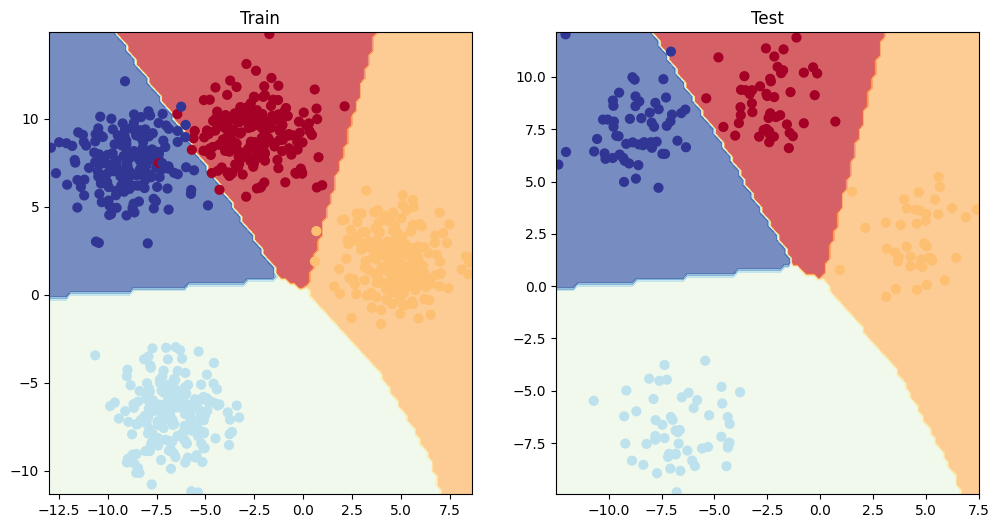

In [69]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [70]:
!pip install torchmetrics

In [71]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy().to(device)

torchmetric_accuracy(y_preds, y_blob_test)

TypeError: Accuracy.__new__() missing 1 required positional argument: 'task'